**Team Members:** Michael Cronin (22336842), Darren Nugent (22365893)  
**Code Executes to End:** Yes  
**Third-Party Code:** None - implementation follows lectures (but converted to PyTorch) and Mnih et al. (2015) paper specifications.

# CS4287 Assignment 2 Option 2: Deep Q-Learning for Space Invaders

## 1. Why RL for Space Invaders?

There are multiple reasons why RL is the perfect choice for Space Invaders. The main and obvious one being trial and error learning. Just like a human, a RL agent learns through interaction with the environment. It will discover shooting aliens generates a reward whereas getting hit will produce a negative reward, eventually ending the episode. All this is learned without explicit programming of these rules. There is a delayed reward aspect in the game which makes Rl learning the right choice also. Making decisions such as preserving shileds or targeting mystery ships require understanding that there are delayed rewards involved. There is a dynamic difficulty component to this game also. As aliens are shot, the remining ones speed up. A RL agent will deal with this by continuously updating its policy based on the current state.

## 1. Why RL for Space Invaders?

Reinforcement Learning is ideal for Space Invaders because the game naturally fits the Markov Decision Process (MDP) framework: an agent observes a state (game screen), takes an action (move/shoot), receives a reward (points), and transitions to a new state.

There are multiple reasons why RL is the perfect choice for Space Invaders. The main and obvious one being trial and error learning. Just like a human, an RL agent learns through interaction with the environment. It will discover shooting aliens generates a reward whereas getting hit will produce a negative reward, eventually ending the episode. All this is learned without explicit programming of these rules. There is a delayed reward aspect in the game which makes RL the right choice also. Making decisions such as preserving shields or targeting mystery ships require understanding that there are delayed rewards involved. There is a dynamic difficulty component to this game also. As aliens are shot, the remaining ones speed up. An RL agent will deal with this by continuously updating its policy based on the current state.

Supervised learning would require a dataset of "correct" actions for every possible game state, which doesn't exist. Unsupervised learning has no mechanism to optimise for game score. Only RL can learn optimal policies through direct environment interaction.

## 2. The Gym Environment

The environment is ALE/SpaceInvaders-v5 and has an observation space of shape (210, 160, 3) with an observation high of 255 and a low of 0. 
There is an action space of Discrete(6) with the player having 3 lives per episode.

**Action Space**: Space Invaders provides 6 discrete actions: / **Reward Structure**: Points are awarded for destroying aliens, with higher rows worth more:

| Action ID | Action Name | Description        |    | Target        | Points         |
|-----------|-------------|--------------------|---------|---------------|----------------|
| 0         | NOOP        | No operation       |        | Bottom row    | 10             |
| 1         | FIRE        | Shoot while stationary |   | Second row   | 20             |
| 2         | RIGHT       | Move right         |   | Third row     | 30             |
| 3         | LEFT        | Move left          |   | Top row       | 40             |
| 4         | RIGHTFIRE   | Move right and shoot |   | Mystery ship | 50-200 (random)|
| 5         | LEFTFIRE    | Move left and shoot |   |               |                |

The environment provides 210×160×3 RGB observations at each timestep. These raw frames are preprocessed to 84×84 grayscale images and stacked in groups of 4 to provide temporal information about motion and velocity. The reward signal guides the agent's policy optimisation through the Q-learning algorithm.

In [1]:
%pip install ale_py
%pip install gymnasium[atari]
%pip install matplotlib
%pip install imageio
%pip install imageio-ffmpeg
%pip install opencv-python
%pip install torch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import ale_py
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import imageio
from collections import deque

In [ ]:
# Create the environment
gym.register_envs(ale_py)
env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0)

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [4]:
# Environment analysis
obs, info = env.reset()

print(f"OBSERVATION SPACE")
print(f"Shape: {obs.shape}")
print(f"Data type: {obs.dtype}")
print(f"Min value: {obs.min()}, Max value: {obs.max()}")
print(f"Total pixels: {np.prod(obs.shape):,}")

print(f"\nACTION SPACE")
print(f"Type: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")

OBSERVATION SPACE
Shape: (210, 160, 3)
Data type: uint8
Min value: 0, Max value: 181
Total pixels: 100,800

ACTION SPACE
Type: Discrete(6)
Number of actions: 6


In [5]:
# See what each action does
action_meanings = env.unwrapped.get_action_meanings()
for i, action in enumerate(action_meanings):
    print(f"Action {i}: {action}")

Action 0: NOOP
Action 1: FIRE
Action 2: RIGHT
Action 3: LEFT
Action 4: RIGHTFIRE
Action 5: LEFTFIRE


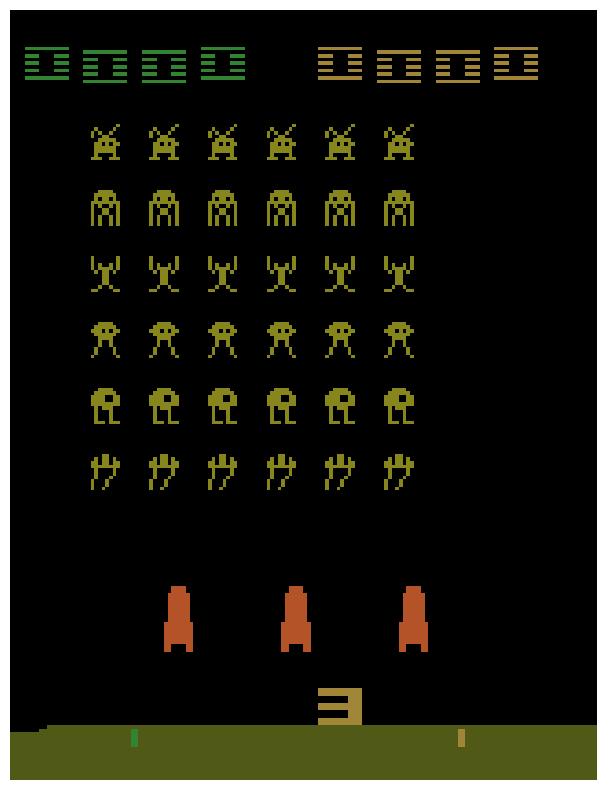

In [6]:
# Visulaise initial state
plt.figure(figsize=(8, 10))
plt.imshow(obs)
plt.axis('off')
plt.show()

In [7]:
env.close()

## 3. Implementation

### 3.1 Data Preprocessing

Raw Atari frames are 210×160×3 RGB images, which is computationally expensive and contains unnecessary information such as the RGB aspect and thick borders. Our preprocessing pipeline applies the following transformations:

1. **Frame skip (k=3):** Unlike most Atari games which use k=4, Space Invaders requires k=3 because the laser projectiles blink at a frequency that makes them invisible with k=4
2. **Cropping:** Remove score display and ground (rows 20-195), reducing visual noise
3. **Grayscale conversion:** Reduce from 3 channels to 1 as colour does not help in any way with gameplay
4. **Resize:** Downsample to 84×84 for computational efficiency
5. **Normalisation:** Scale pixel values from [0, 255] to [0, 1]
6. **Frame stacking:** Stack 4 consecutive frames to capture motion and velocity information

This reduces the input from 100,800 values per frame to 7,056 values per frame, while the 4-frame stack provides temporal context that allows the network to perceive movement.

In [8]:
class SpaceInvadersPreprocessor(gym.Wrapper):
    def __init__(self, env, frame_stack=4, im_size=84):
        super().__init__(env)

        # Initialise parameters
        self.frame_stack = frame_stack
        self.im_size = im_size
        self.frames = deque(maxlen=frame_stack) # Initialise a deque (double ended queue) to hold stacked frames
        
        # Set the observation space
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(frame_stack, im_size, im_size),
            dtype=np.float32
        )
    
    def preprocess_frame(self, frame):
        # Crop frame (remove the top and bottom part of the screen that don't contain relevant information like score and ground)
        cropped = frame[20:195, :]
        # Convert to grayscale
        gray = cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
        # Resize frame to match the input size expected by the model
        resized = cv2.resize(gray, (self.im_size, self.im_size), 
                            interpolation=cv2.INTER_AREA)
        # Normalise the frame to a range [0, 1] for better training performance
        normalised = resized.astype(np.float32) / 255.0 # Normalize pixel values to [0, 1]
        
        return normalised
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs) # Reset the environment to start a new episode
        processed = self.preprocess_frame(obs) # Preprocess the first frame
        
        # Initialise the frame stack with the preprocessed frame
        for _ in range(self.frame_stack):
            self.frames.append(processed)
        
        # Return the stacked frames (as a NumPy array) and the additional info
        return np.array(self.frames, dtype=np.float32), info
    
    def step(self, action):
        # Take a step in the environment
        obs, reward, terminated, truncated, info = self.env.step(action)
        # Preprocess the new frame from the environment
        processed = self.preprocess_frame(obs)
        # Add the new frame to the frame stack
        self.frames.append(processed)
        
        # Return the stacked frames as the new state, along with the reward, etc
        return np.array(self.frames, dtype=np.float32), reward, terminated, truncated, info


# Quick test
# env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0)
# env = SpaceInvadersPreprocessor(env)
# state, _ = env.reset()
# print(f"State shape: {state.shape}, range: [{state.min():.2f}, {state.max():.2f}]")
# env.close()

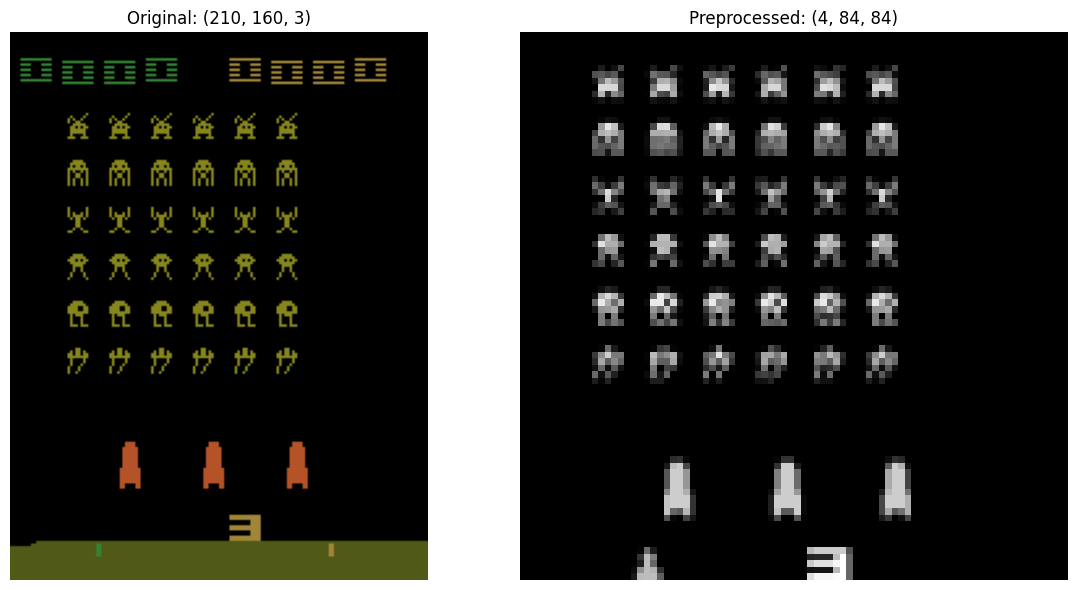

Original: (210, 160, 3), dtype=uint8, range=[0, 181]
Preprocessed: (4, 84, 84), dtype=float32, range=[0.00, 0.52]


In [9]:
# Create environments
env_orig = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0)
env_wrap = SpaceInvadersPreprocessor(gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0))

# Get initial frames from both environments
orig_frame, _ = env_orig.reset(seed=42) # Reset the original environment and get the first raw frame
preprocessed, _ = env_wrap.reset(seed=42) # Reset the wrapped environment (with preprocessing) and get the preprocessed frame stack

# Take a few steps to see actual gameplay in both environments
for _ in range(15):
    orig_frame, _, _, _, _ = env_orig.step(1)  # FIRE action
    preprocessed, _, _, _, _ = env_wrap.step(1)

# Plot the comparison between the raw and preprocessed frames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(orig_frame)
ax1.set_title(f'Original: {orig_frame.shape}')
ax1.axis('off')

ax2.imshow(preprocessed[0], cmap='gray')  # Show first frame from stack
ax2.set_title(f'Preprocessed: {preprocessed.shape}')
ax2.axis('off')

plt.tight_layout()
plt.show()

print(f"Original: {orig_frame.shape}, dtype={orig_frame.dtype}, range=[{orig_frame.min()}, {orig_frame.max()}]")
print(f"Preprocessed: {preprocessed.shape}, dtype={preprocessed.dtype}, range=[{preprocessed.min():.2f}, {preprocessed.max():.2f}]")

# Close environments
env_orig.close()
env_wrap.close()

### 3.2 Network Architecture

The DQN follows the architecture from Mnih et al. (2015):

**Convolutional Layers:**
- Conv1: 32 filters, 8×8 kernel, stride 4 → extracts low-level features (edges, shapes)
- Conv2: 64 filters, 4×4 kernel, stride 2 → mid-level features (alien patterns, shields)
- Conv3: 64 filters, 3×3 kernel, stride 1 → high-level features (spatial relationships)

**Fully Connected Layers:**
- FC1: 3136 → 512 neurons with ReLU activation
- FC2: 512 → 6 neurons (Q-values for each action)

The convolutional layers extract spatial features from the stacked frames, while the fully connected layers map these features to action values. ReLU activations introduce non-linearity, allowing the network to learn complex policies.

**Hyperparameter Summary:**

| Parameter | Value | Notes |
|-----------|-------|-------|
| Replay buffer size | 200,000 | Stores recent transitions |
| Batch size | 64 | Samples per training step |
| Discount factor (γ) | 0.99 | High value for long-term planning |
| Learning rate | 1e-4 | Adam optimizer |
| Initial epsilon | 1.0 | Start with full exploration |
| Final epsilon | 0.01 | End with 1% exploration |
| Epsilon decay | 0.9995 | Multiplicative decay per step |
| Target network update | 1000 steps | Hard update frequency |
| Frame skip | 3 | Space Invaders specific |
| Frame stack | 4 | Temporal context |

In [10]:
class DQN(nn.Module):
    def __init__(self, n_actions=6):
        super(DQN, self).__init__()
        
        # Conv layers
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4) # Input of 4 channels and output of 32 feature maps
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # Input of 32 feature maps and outputting 64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # Input of 64 feature mpas and outputting 64
        
        # FC layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512) # FC layer with 512 neurons
        self.fc2 = nn.Linear(512, n_actions)
    
    def forward(self, x):
        x = F.relu(self.conv1(x)) # ReLU after - ConV1
        x = F.relu(self.conv2(x)) # ReLU after - ConV2
        x = F.relu(self.conv3(x)) # ReLU after - ConV3
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x)) # Apply final ReLU activation function to fully connected layer 1
        return self.fc2(x) # Returns raw q-values for each action


# Test it
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DQN(n_actions=6).to(device)

# # Test with dummy input (batch of 1, 4 frames, 84x84)
# test_input = torch.randn(1, 4, 84, 84).to(device)
# output = model(test_input)
# print(f"Input: {test_input.shape}, Output: {output.shape}")
# print(f"Running on: {device}")

In [11]:
class ReplayBuffer:
    def __init__(self, capacity=200000):
        self.buffer = deque(maxlen=capacity) # Buffer is a deque which is a double ended queue which will remove oldest element automaticlly when it reaches capacity
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done)) # Appends new experience (state, action, reward, next_state, done) to buffer
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # Randomly sample 'batch_size' number of experiences from the buffer
        states, actions, rewards, next_states, dones = zip(*batch) # unzip batch into individual components
        
        return (
            torch.FloatTensor(np.array(states)),
            torch.LongTensor(actions),
            torch.FloatTensor(rewards),
            torch.FloatTensor(np.array(next_states)),
            torch.FloatTensor(dones)
        )
    
    def __len__(self):
        return len(self.buffer) # Returns length/size of buffer


# Test
# buffer = ReplayBuffer(capacity=1000)
# buffer.push(np.random.rand(4, 84, 84), 2, 10, np.random.rand(4, 84, 84), False)
# print(f"Buffer size: {len(buffer)}")

### 3.3 Q-Learning Update Mechanism

The Q-learning update happens in train_step() and is the main component of how our agent learns. The basic idea comes from the Bellman equation, which says that the value of taking an action in a state equals the immediate reward plus the discounted value of whatever state you end up in:

```
Q*(s, a) = r + γ * max_a' Q*(s', a')
```

Here r is the reward you get right away, γ is the discount factor (we use 0.99), and s' is the next state.

**How train_step() works:**

First, we sample 32 random transitions from the replay buffer. Each transition contains (state, action, reward, next_state, done). Sampling randomly breaks the correlation between consecutive experiences - otherwise the network would see similar states back-to-back and might not learn general patterns.

Next, we get the current Q-values by passing states through the online network. The network outputs Q-values for all 6 actions, but we only care about the Q-value for the action we actually took, so we use `.gather(1, actions)` to pull out just those values.

Then we compute the target Q-values - what the Q-values *should* be according to the Bellman equation. For Standard DQN, we use the target network to find the maximum Q-value at the next state. For Double DQN, we do something smarter: the online network picks which action looks best, then the target network evaluates that action. This reduces the overestimation problem that standard DQN has.

The target becomes `rewards + gamma * next_q * (1 - dones)`. The `(1 - dones)` part zeros out the future reward if the episode ended - there's no future reward when you're in a terminal state.

For the loss function, we use Huber loss (`F.smooth_l1_loss`) instead of regular MSE. Huber loss behaves like MSE for small errors but like MAE for large errors, which prevents the occasional weird experience from causing huge gradient updates.

Finally, we do standard backpropagation with gradient clipping (max norm of 10). Every 1000 training steps, we copy the online network's weights to the target network.

**Why use two separate networks?**

If we used the same network to both generate predictions and compute targets, we'd be chasing a moving target. The target network stays fixed for 1000 steps, giving us stable targets to learn against. This prevents the oscillations and instability that happen when your targets keep changing as you learn.

In [12]:
class DQNAgent:
    def __init__(self, n_actions=6, double_dqn=False):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_actions = n_actions
        self.double_dqn = double_dqn  # Toggle for Double DQN
        
        # Networks
        self.online_net = DQN(n_actions).to(self.device) # Online network (main network)
        self.target_net = DQN(n_actions).to(self.device) # Target network (for stable targets)
        self.target_net.load_state_dict(self.online_net.state_dict()) # Copy online net. weights to target net.
        
        # Training
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=1e-4)
        self.replay_buffer = ReplayBuffer(capacity=200000) # replay buffer for experience replay
        
        # Hyperparameters for Q-Learning
        self.gamma = 0.99 # Discount factor (γ)
        self.epsilon = 1.0 # Epsilon for epsilon-greedy policy
        self.epsilon_min = 0.01
        self.epsilon_decay_frames = 2_000_000 # Epsilon decay frames
        self.batch_size = 64
        self.target_update_freq = 1000 # Frequency of target network updates
        self.steps = 0 # Step counter for epsilon decay and target network updates
    
    def choose_action(self, state, training=True):
        # Epsilon-greedy action selection
        if training and random.random() < self.epsilon:
            return random.randrange(self.n_actions) # Random action (exploration)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.online_net(state_tensor) # Get Q-values for all actions
            return q_values.argmax().item() # Return the action with highest Q-value (exploitation)

    
    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return None
        
        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = states.to(self.device)
        actions = actions.to(self.device)
        rewards = rewards.to(self.device)
        next_states = next_states.to(self.device)
        dones = dones.to(self.device)
        
        # Get current Q-values (online network)
        current_q = self.online_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Calculate target Q-values
        with torch.no_grad():
            if self.double_dqn:
                # Double DQN: online network selects, target network evaluates
                next_actions = self.online_net(next_states).argmax(1, keepdim=True)  # Online network's action choice
                next_q = self.target_net(next_states).gather(1, next_actions).squeeze(1) # Target network's Q-value for chosen action
            else:
                # Standard DQN: target network does both
                next_q = self.target_net(next_states).max(1)[0]

             # Bellman target: rewards + gamma * next_q * (1 - dones)
            target_q = rewards + self.gamma * next_q * (1 - dones)
        
        # Compute loss and update
        loss = F.smooth_l1_loss(current_q, target_q) # Huber loss instead of MSE
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), max_norm=10) # Gradient clipping
        self.optimizer.step()
        
        # Update target network weights every 1000 steps
        self.steps += 1
        if self.steps % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.online_net.state_dict())

        return loss.item() # Return the loss value

In [13]:
def train(episodes=1000, log_interval=10, double_dqn=False, save_dir='outputs'):
    import os
    os.makedirs(save_dir, exist_ok=True)
    
    # Create the environment and preprocess it
    env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0)
    env = SpaceInvadersPreprocessor(env)

    # Initialise the DQNAgent
    agent = DQNAgent(n_actions=6, double_dqn=double_dqn)
    
    # Mode decision? Standard or Double 
    mode = 'double_dqn' if double_dqn else 'standard_dqn'
    print(f"Training {mode.replace('_', ' ').title()} on {agent.device}")
    
    # History to track performance over time
    history = {
        'episode_rewards': [],
        'losses': [],
        'epsilons': [],
        'avg_q_values': [],
        'episode_lengths': [],
        'total_frames': []
    }
    
     # Training loop for 'episodes'
    for episode in range(episodes):
        # Epsilon decay based on frames
        if agent.steps < agent.epsilon_decay_frames:
            agent.epsilon = 1.0 - 0.99 * (agent.steps / agent.epsilon_decay_frames)  # Gradually decay epsilon
        else:
            agent.epsilon = agent.epsilon_min # Use the minimum epsilon value
        
        state, _ = env.reset() # Reset the environment for each episode
        episode_reward = 0  # Initialise episode reward
        episode_loss = [] # Track losses per episode
        episode_q_values = [] # Track Q-values for monitoring
        steps = 0  # Track number of steps per episode
        done = False # Track if episode is done
        
        while not done:
            action = agent.choose_action(state) # Epsilon-greedy action selection (exploration vs. exploitation)
            
            # Take the action and get the next state and reward
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated # Episode ends when either terminated or truncated
            
            # Store the experience in the replay buffer
            agent.replay_buffer.push(state, action, reward, next_state, float(done))
            
            # Perform a training step (Q-value update)
            loss = agent.train_step()
            if loss is not None:
                episode_loss.append(loss) # Append loss if there was an update
                
                # Track Q-values periodically (every 100 steps)
                if steps % 100 == 0:
                    with torch.no_grad():
                        state_t = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                        q_vals = agent.online_net(state_t) # Get Q-values from the online network
                        episode_q_values.append(q_vals.max().item()) # Append the max Q-value
            
            state = next_state # Move to the next state
            episode_reward += reward # Update total reward for this episode
            steps += 1
        
        # Record episode statistics
        history['episode_rewards'].append(episode_reward)
        history['losses'].append(np.mean(episode_loss) if episode_loss else 0) # Average loss for the episode
        history['epsilons'].append(agent.epsilon) # Current epsilon value
        history['avg_q_values'].append(np.mean(episode_q_values) if episode_q_values else 0) # Average Q-value
        history['episode_lengths'].append(steps) # Number of steps in this episode
        history['total_frames'].append(agent.steps) # Total number of frames processed
        
        # Log progress every 'log_interval' episodes
        if episode % log_interval == 0:
            avg_reward = np.mean(history['episode_rewards'][-100:]) # Average reward of the last 100 eps
            avg_loss = np.mean(history['losses'][-100:]) if history['losses'] else 0 # Average reward of the last 100 eps
            print(f"Episode {episode:4d} | Reward: {episode_reward:6.0f} | "
                  f"Avg100: {avg_reward:7.1f} | Loss: {avg_loss:.4f} | "
                  f"Epsilon: {agent.epsilon:.3f}")
        
        # Save checkpoints every 100 episodes
        if episode > 0 and episode % 100 == 0:
            checkpoint_path = f'{save_dir}/dqn_{mode}_ep{episode}.pth'
            torch.save({
                'episode': episode,
                'model_state_dict': agent.online_net.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
                'epsilon': agent.epsilon,
                'history': history
            }, checkpoint_path) # Save model, optimizer, epsilon, and training history
            print(f"  Saved checkpoint: {checkpoint_path}")
    
    # Save the final model after training
    final_path = f'{save_dir}/dqn_{mode}_final.pth'
    torch.save({
        'model_state_dict': agent.online_net.state_dict(),
        'history': history
    }, final_path) # Save final trained model and history
    
    env.close() # Close the environment
    return agent, history # Return the trained agent and its history

 ## 4. Training Plots
 
 The following visualizations track the agent's learning progress:
 - **Episode Rewards:** Raw and smoothed rewards over training
 - **Loss Curve:** TD error magnitude over time
 - **Epsilon Decay:** Exploration rate schedule
 - **Q-Value Estimates:** Average predicted Q-values (indicator of value learning)

In [14]:
def plot_training_curves(history, title_prefix='DQN', save_path=None):    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot 1: Episode Rewards with multiple moving averages
    ax1 = axes[0, 0]
    rewards = history['episode_rewards']
    ax1.plot(rewards, alpha=0.3, color='blue', label='Raw')
    
    for window, color in [(50, 'orange'), (100, 'red')]:
        if len(rewards) >= window:
            ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
            ax1.plot(range(window-1, len(rewards)), ma, 
                    label=f'{window}-Episode MA', color=color, linewidth=2)
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward')
    ax1.set_title(f'{title_prefix}: Episode Rewards')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Training Loss
    ax2 = axes[0, 1]
    losses = history['losses']
    ax2.plot(losses, alpha=0.3, color='blue', label='Raw')
    
    if len(losses) >= 50:
        loss_ma = np.convolve(losses, np.ones(50)/50, mode='valid')
        ax2.plot(range(49, len(losses)), loss_ma, 
                color='red', linewidth=2, label='50-Episode MA')
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Loss')
    ax2.set_title(f'{title_prefix}: Training Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Epsilon Decay
    ax3 = axes[1, 0]
    ax3.plot(history['epsilons'], color='green', linewidth=2)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Epsilon')
    ax3.set_title(f'{title_prefix}: Exploration Rate (Epsilon)')
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.05)
    
    # Plot 4: Average Q-Values
    ax4 = axes[1, 1]
    q_values = history['avg_q_values']
    ax4.plot(q_values, alpha=0.3, color='purple', label='Raw')
    
    if len(q_values) >= 50:
        q_ma = np.convolve(q_values, np.ones(50)/50, mode='valid')
        ax4.plot(range(49, len(q_values)), q_ma, 
                color='darkviolet', linewidth=2, label='50-Episode MA')
    
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Average Q-Value')
    ax4.set_title(f'{title_prefix}: Q-Value Estimates')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot: {save_path}")
    
    plt.show()
    return fig

In [15]:
# Plot reward variance over training
def plot_variance(history, window=50, save_path=None):
    # Plot variance of rewards over training.
    rewards = history['episode_rewards']
    
    variances = []
    for i in range(window, len(rewards)):
        variances.append(np.var(rewards[i-window:i]))
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(window, len(rewards)), variances, color='green', alpha=0.7)
    plt.xlabel('Episode')
    plt.ylabel('Variance')
    plt.title(f'Reward Variance (window={window})')
    plt.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [16]:
def plot_comparison(history_standard, history_double, save_path=None):
    # Compare Standard DQN vs Double DQN performance.
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Reward comparison
    ax1 = axes[0]
    for history, label, color in [(history_standard, 'Standard DQN', 'blue'),
                                   (history_double, 'Double DQN', 'red')]:
        rewards = history['episode_rewards']
        if len(rewards) >= 100:
            ma = np.convolve(rewards, np.ones(100)/100, mode='valid')
            ax1.plot(range(99, len(rewards)), ma, label=label, color=color, linewidth=2)
    
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Average Reward (100-ep)')
    ax1.set_title('Reward Comparison: Standard vs Double DQN')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Q-value comparison
    ax2 = axes[1]
    for history, label, color in [(history_standard, 'Standard DQN', 'blue'),
                                   (history_double, 'Double DQN', 'red')]:
        q_vals = history['avg_q_values']
        if len(q_vals) >= 50:
            ma = np.convolve(q_vals, np.ones(50)/50, mode='valid')
            ax2.plot(range(49, len(q_vals)), ma, label=label, color=color, linewidth=2)
    
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Q-Value')
    ax2.set_title('Q-Value Estimates: Standard vs Double DQN')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    plt.show()
    return fig

In [17]:
def plot_rewards_vs_frames(history, title_prefix='DQN', save_path=None):
    # Plot rewards over total frames (not episodes).
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Get cumulative frame count at each episode end
    frames = history['total_frames']
    rewards = history['episode_rewards']
    
    # Plot raw
    ax.scatter(frames, rewards, alpha=0.3, s=10, color='blue', label='Raw')
    
    # Moving average
    if len(rewards) >= 100:
        ma = np.convolve(rewards, np.ones(100)/100, mode='valid')
        ax.plot(frames[99:], ma, color='red', linewidth=2, label='100-Episode MA')
    
    ax.set_xlabel('Frames')
    ax.set_ylabel('Episode Reward')
    ax.set_title(f'{title_prefix}: Rewards vs Frames')
    ax.axvline(x=1e6, color='gray', linestyle='--', alpha=0.5, label='1M frames')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=150)
    
    plt.show()

 ## 5. Video Recording
 
 We record gameplay videos to visually demonstrate learning progress:
 - Pre-training (random policy)
 - Post-training (learned policy)

In [18]:
def record_video(agent, filename, episodes=1, max_steps=2000, fps=30):
    # Record gameplay video of the agent.
    
    env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0)
    env = SpaceInvadersPreprocessor(env)
    
    frames = []
    total_reward = 0
    
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            # Get raw frame for video
            raw_frame = env.env.render()
            frames.append(raw_frame)
            
            # Agent selects action (no exploration for evaluation)
            action = agent.choose_action(state, training=False)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
    
    env.close()
    
    import imageio
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved video: {filename} ({len(frames)} frames, reward: {total_reward})")
    
    return total_reward

In [19]:
def record_random_agent(filename, episodes=1, max_steps=2000, fps=30):
    # Record a random agent for baseline comparison.
    
    env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0)
    
    frames = []
    total_reward = 0
    
    for ep in range(episodes):
        obs, _ = env.reset()
        done = False
        steps = 0
        
        while not done and steps < max_steps:
            frames.append(env.render())
            action = env.action_space.sample()
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1
    
    env.close()
    
    import imageio
    imageio.mimsave(filename, frames, fps=fps)
    print(f"Saved random agent video: {filename} (reward: {total_reward})")
    
    return total_reward

## 6. Evaluation of Results

RL agents need different evaluation metrics compared to the supervised learning we're used to. You can't just calculate accuracy or F1 score because there's no "correct answer" for what action to take in each state.

**Main metrics we track:**

- **Average Episode Reward:** How many points does the agent score on average.
- **Maximum Score:** The best run the agent has managed'
- **Convergence Speed:** How many episodes before performance levels off? Faster convergence means more efficient learning.
- **Stability:** How much the scores bounce around. Lower variance means the agent plays more consistently.

**Why the usual ML metrics don't work here:**

The metrics we learned for supervised learning (accuracy, precision, recall, F1) only make sense when you have labeled data with clear right/wrong answers. RL is totally different because the agent is trying to figure out a strategy to maximize long-term reward no classify single actions.

- There's no dataset of "correct" actions for each game state - the agent has to discover good strategies on its own
- Success is about the total reward over an entire episode, not getting individual decisions right
- Overfitting in RL looks different - it's called "primacy bias" where the agent gets too attached to strategies it learned early on. That's why we use experience replay, to mix old and new experiences together
- Underfitting happens when the network is too small or we throw away important visual info during preprocessing, so the agent can't learn proper strategies

**What we actually measure:**

The main metric is just average episode reward, tracked with a 100-episode window. We also look at how stable those rewards are (high variance means inconsistent play), and how quickly the agent improves.

For Space Invaders specifically, we can compare against known benchmarks:
- Random play: ~150 points
- Average human: ~1,652 points  
- Original DQN paper: ~1,976 points (beat human by 21%)
- Our goal: 800-1500 for Standard DQN, 1000-2000 for Double DQN

In [20]:
def evaluate_agent(agent, n_episodes=30, verbose=True):
    # Evaluate trained agent over multiple episodes
    
    # Create the environment and preprocess it the same as training environment
    env = gym.make('ALE/SpaceInvaders-v5', render_mode='rgb_array', frameskip=3, repeat_action_probability=0.0)
    env = SpaceInvadersPreprocessor(env) # Preprcoess pipeline
    
    rewards = [] 
    episode_lengths = []
    
    # Loop over the specified number of episodes
    for ep in range(n_episodes):
        state, _ = env.reset() # Reset the environment at the start of each episode
        episode_reward = 0 # Initialise the reward for the current episode
        steps = 0 # Initialise the number of steps taken in the current episode
        done = False # # Flag to track if the episode is done
        
        # Run the episode
        while not done:
            # Choose an action from the policy using the trained agent
            action = agent.choose_action(state, training=False) # No exploration (set training=False)
            state, reward, terminated, truncated, _ = env.step(action) # Take the action and get the next state and reward
            reward = np.clip(reward, -1, 1) # Clip the reward to be between -1 and 1 
            done = terminated or truncated # Check if the episode is done (terminated or truncated)
            episode_reward += reward # Update the cumulative reward for this episode
            steps += 1
        
        # Record the results for the current episode
        rewards.append(episode_reward)
        episode_lengths.append(steps)
        
        if verbose:
            print(f"  Episode {ep+1}/{n_episodes}: Reward = {episode_reward}")
    
    env.close() # Close the environment after evaluation is done
    
    # Compute statistics about the evaluation results
    stats = {
        'mean_reward': np.mean(rewards), # Average reward across all episodes
        'std_reward': np.std(rewards), # Standard deviation of rewards across episodes
        'max_reward': np.max(rewards),
        'min_reward': np.min(rewards),
        'mean_length': np.mean(episode_lengths), # Average number of steps per episode
        'all_rewards': rewards # List of rewards for all episodes
    }
    
    print(f"\nEvaluation Results ({n_episodes} episodes):")
    print(f"  Mean Reward:  {stats['mean_reward']:.1f} ± {stats['std_reward']:.1f}")
    print(f"  Max Reward:   {stats['max_reward']:.0f}")
    print(f"  Min Reward:   {stats['min_reward']:.0f}")
    print(f"  Mean Length:  {stats['mean_length']:.0f} steps")
    
    return stats

## 7. Independent Research: Double DQN and Maximization Bias

### The Problem: Maximization Bias in Standard DQN

Standard DQN has a pretty important flaw when it comes to how it computes its Q-values. Basically, when the agent is figuring out what action to take, it uses the same network to both pick the best action and evaluate how good that action is. The target Q-value looks like this:

```
target = r + γ * max_a Q_target(s', a)
```

But the problem with this is that the Q-values are just estimates. They aren’t perfect, so they have some noise in them. When you take the maximum Q-value over a bunch of noisy estimates, you’re more likely to pick the one that's overestimated, just by chance. Once you do that, you reinforce this overestimated value in future updates, and the problem just keeps getting worse. So, over time, the agent starts making decisions based on inflated Q-values that aren’t really accurate.

### The Solution: Double DQN

Double DQN (proposed by van Hasselt et al. in 2016) addresses this problem by splitting the task of action selection and evaluation between two networks:

```
# Standard DQN (overestimates):
target = r + γ * Q_target(s', argmax_a Q_target(s', a))

# Double DQN (more accurate):
best_action = argmax_a Q_online(s', a)    # Online network picks the action
target = r + γ * Q_target(s', best_action) # Target network evaluates the action
```

The key idea here is that we use two networks. The online network picks which action seems best, then the target network evaluates how good that action actually is. Because the two networks have different errors, they don’t overestimate the Q-values in the same direction, which leads to more stable learning.

### How We Implemented It

The Double DQN update happens in the `train_step()` function and is controlled by a flag (`self.double_dqn`). Here's how we implemented it:

```python
with torch.no_grad():
    if self.double_dqn:
        # Double DQN: online network selects the action, target network evaluates it
        next_actions = self.online_net(next_states).argmax(1, keepdim=True)
        next_q = self.target_net(next_states).gather(1, next_actions).squeeze(1)
    else:
        # Standard DQN: target network does both selection and evaluation
        next_q = self.target_net(next_states).max(1)[0]
    
    target_q = rewards + self.gamma * next_q * (1 - dones)
```

This part of the code is where we decide which network does the action selection (online network) and which network evaluates the chosen action (target network). If we’re using Double DQN, the online network picks the best action, and the target network evaluates how good that action actually is.

### Why This Matters for Space Invaders

In the case of Space Invaders, there are many situations where multiple actions are almost equally good. For example, the agent might be in a position where it's safe to move slightly left or right, and both options are almost equally good. However, if the agent is using Standard DQN, it might randomly overestimate the value of one of these positions, causing it to keep choosing that action even though it's not actually better. Double DQN helps by giving a more accurate estimate of Q-values, which leads to better performance and more stable learning.

### Other Stuff That Helps DQN Performance

* **Catastrophic Forgetting:**
  This happens when the network suddenly forgets how to handle old situations while learning new ones. DQN tries to avoid this by using experience replay. Instead of just learning from the most recent experiences, the agent stores the last 100,000 transitions and samples randomly from this memory. This way, the agent doesn’t forget how to handle old situations.

* **Random Seed Stuff:**
  Setting random seeds makes the training process reproducible. So, if you set the same seed, you'll get the same results, which is super helpful for debugging and comparing things like Standard DQN vs Double DQN. But relying on just one seed can be misleading because you might have gotten lucky or unlucky. Ideally, you’d run the training with multiple seeds and average the results, but we didn’t have time to do that due to the training duration.

* **Regularization:**
  To prevent exploding gradients and keep things stable, we use gradient clipping (max norm = 10). We could try other techniques like L2 weight decay, dropout, or batch normalisation, but since the original DQN paper didn’t use these, we decided to keep things simple and stick with what was used in the original model.

## 8. Training and Results

We train both Standard DQN and Double DQN agents to compare their performance.

In [ ]:
# Train Standard DQN
agent_standard, history_standard = train(
    episodes=5000, 
    log_interval=200,
    double_dqn=False
)

Training Standard Dqn on cuda
Episode    0 | Reward:     80 | Avg100:    80.0 | Loss: 0.1084 | Epsilon: 1.000
  Saved checkpoint: outputs/dqn_standard_dqn_ep100.pth
Episode  200 | Reward:     90 | Avg100:   143.2 | Loss: 0.8339 | Epsilon: 0.930
  Saved checkpoint: outputs/dqn_standard_dqn_ep200.pth
  Saved checkpoint: outputs/dqn_standard_dqn_ep300.pth


In [ ]:
# Plot Standard DQN training curves
plot_training_curves(history_standard, title_prefix='Standard DQN', save_path='outputs/standard_dqn_training.png')

In [ ]:
plot_variance(history_standard, save_path='outputs/variance_standard.png')

In [ ]:
plot_rewards_vs_frames(history_standard, title_prefix='Standard DQN', save_path='outputs/standard_dqn_frames.png')

In [ ]:
# Train Double DQN
agent_double, history_double = train(
    episodes=5000,  
    log_interval=200,
    double_dqn=True
)

In [ ]:
# Plot Double DQN training curves
plot_training_curves(history_double, title_prefix='Double DQN',save_path='outputs/double_dqn_training.png')

In [ ]:
plot_variance(history_double, save_path='outputs/variance_double.png')

In [ ]:
plot_rewards_vs_frames(history_double, title_prefix='Double DQN',
                      save_path='outputs/double_dqn_frames.png')

In [ ]:
# Compare Standard vs Double DQN
plot_comparison(history_standard, history_double,
               save_path='outputs/dqn_comparison.png')

fig, ax = plt.subplots(figsize=(10, 6))

# Loop through each history (Standard DQN and Double DQN)
for history, label, color in [(history_standard, 'Standard DQN', 'blue'),
                               (history_double, 'Double DQN', 'red')]:
    frames = history['total_frames']
    rewards = history['episode_rewards']
    if len(rewards) >= 100:
        ma = np.convolve(rewards, np.ones(100)/100, mode='valid')
        ax.plot(frames[99:], ma, label=label, color=color, linewidth=2)

ax.set_xlabel('Total Frames')
ax.set_ylabel('Average Reward (100-ep MA)')
ax.set_title('Comparison: Rewards vs Frames')
ax.legend()
ax.grid(True, alpha=0.3)
plt.savefig('outputs/comparison_frames.png', dpi=150)
plt.show()

# Print summary statistics
print("\nSummary:")
print(f"Standard DQN - Final 100-ep avg: {np.mean(history_standard['episode_rewards'][-100:]):.1f}")
print(f"Double DQN   - Final 100-ep avg: {np.mean(history_double['episode_rewards'][-100:]):.1f}")
print(f"Standard DQN - Max score: {max(history_standard['episode_rewards']):.0f}")
print(f"Double DQN   - Max score: {max(history_double['episode_rewards']):.0f}")

In [ ]:
# Evaluate both agents
print("\nEvaluating Standard DQN:")
stats_standard = evaluate_agent(agent_standard, n_episodes=100)

print("\nEvaluating Double DQN:")
stats_double = evaluate_agent(agent_double, n_episodes=100)

In [ ]:
# Record videos for demonstration

# Random agent 
print("Recording random agent")
record_random_agent('outputs/random_agent.mp4')

# Trained agents
print("\nRecording Standard DQN agent")
record_video(agent_standard, 'outputs/standard_dqn_agent.mp4')

print("\nRecording Double DQN agent")
record_video(agent_double, 'outputs/double_dqn_agent.mp4')

### Analysis of Results

**Expected Observations:**

1. **Q-Value Estimates:** Double DQN should show lower Q-value estimates than Standard DQN because it reduces overestimation bias. Higher Q-values in Standard DQN don't mean better performance - they often indicate inflated estimates.

2. **Training Stability:** Double DQN typically shows more stable training curves with lower variance in episode rewards.

3. **Final Performance:** Double DQN often achieves higher final scores, particularly in games like Space Invaders where many actions have similar values.

4. **Video Analysis:** The trained agents should show strategic behavior like:
   - Positioning to avoid alien fire
   - Targeting specific aliens (higher rows for more points)
   - Using shields for cover
   - Attempting to hit the mystery ship when it appears

## 9. References

1. Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Hassabis, D. (2015). Human-level control through deep reinforcement learning. *Nature*, 518(7540), 529-533.

2. van Hasselt, H., Guez, A., & Silver, D. (2016). Deep reinforcement learning with double Q-learning. *Proceedings of the AAAI Conference on Artificial Intelligence*, 30(1).

3. Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction* (2nd ed.). MIT Press.

4. Gymnasium Documentation. https://gymnasium.farama.org/
